In [1]:
from model_training import *
import pandas as pd
import numpy as np
from scripts.essentials import *
from scripts.plots import *
from scripts.train_utilities import *
from neuralforecast.losses.pytorch import RMSE

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Nie można odnaleźć określonej procedury
  warn(f"Failed to load image Python extension: {e}")


In [2]:
prefix = "NFLX"
FINAL_COLUMNS = ['mean_future', 'mean_influential','mean_trustworthy', 'mean_clickbait','norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14']
df_without_weekends = pd.read_csv("csv/"+prefix+'_without_weekends.csv')
df_without_weekends['DateGen'] = pd.date_range(start='2021-01-01', end='2023-11-26', freq='D')[:len(df_without_weekends)]
max_date = df_without_weekends['DateGen'].max()
test_start_date = max_date - pd.DateOffset(days=59)
val_start_date = test_start_date - pd.DateOffset(days=40)
train_set, val_set, test_set = split_data(df_without_weekends, 'DateGen', val_start_date, test_start_date, start_date_train = '2021-01-01')
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

cols_min_max = ['^GSPC_Volume', 'NFLX_Volume',
'daily_variation', 'high_close_pressure', 'low_open_pressure',
'low_norm', 'close_norm', 'high_norm', 'open_norm']

train_set, scaler_min_max = min_max_scale(train_set,'Date', cols_min_max, train_data=True, scaler=None)
val_set = min_max_scale(val_set,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)
test_set = min_max_scale(test_set,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)

train_set = train_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
val_set = val_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
test_set = test_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
train_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
val_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
test_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
train_set['unique_id'] = prefix
val_set['unique_id'] = prefix
test_set['unique_id'] = prefix

(744, 54)
(40, 54)
(60, 54)


In [6]:
############### NBEATS #################
horizon = 5
model_name = 'NBEATS'
max_steps = 10
random_seed = 1
loss_func = mean_squared_error
stack_types = ['seasonality', 'trend', 'identity']
scaler_type = 'standard'
loss=RMSE()

study = optuna.create_study(direction='minimize')
study.optimize(partial(objective, train_set=train_set, val_set=val_set, loss=loss, model_name=model_name, horizon=horizon, hist_exog_list=FINAL_COLUMNS, max_steps=max_steps, random_seed=random_seed, loss_func=loss_func, scaler_type=scaler_type), n_trials=2)
prms = study.best_trial.params
# Predykcja na podstawie najlepszych hiperparametrów
n_blocks = [prms['n_blocks_season'], prms['n_blocks_trend'], prms['n_blocks_ident']]
mlp_units=[[prms['mlp_units'], prms['mlp_units']]]*prms['num_hidden']
models = [NBEATS(
                 h=horizon,
                 loss=loss,
                 max_steps=max_steps,
                 hist_exog_list=FINAL_COLUMNS,
                 input_size=prms['input_size'],
                 stack_types=stack_types,
                 mlp_units=mlp_units,
                 n_blocks=n_blocks,
                 learning_rate=prms['learning_rate'],
                 n_harmonics=prms['n_harmonics'],
                 n_polynomials=prms['n_polynomials'],
                 scaler_type=scaler_type,
                random_seed=random_seed
                 )]

# Pipeline, który robi predykcję batchami co ileś dni, ustalane przez horizon
loss_val, predictions_val = pipeline_train_predict(models, train_set, val_set, horizon, mean_squared_error, model_name)
# Merge train and val sets
train_val_set = pd.concat([train_set, val_set])
loss_test, predictions_test = pipeline_train_predict(models, train_val_set, test_set, horizon, mean_squared_error, model_name)

[I 2023-12-18 21:51:27,717] A new study created in memory with name: no-name-c3b6beb1-58a4-4f05-90b7-b913a87e6010
Seed set to 1


744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.76it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.89it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.70it/s]
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.65it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.48it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 209.63it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.11it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.65it/s]

[I 2023-12-18 21:51:35,986] Trial 0 finished with value: 166.28039769905178 and parameters: {'input_size': 7, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 5, 'learning_rate': 0.05208060292448183}. Best is trial 0 with value: 166.28039769905178.
Seed set to 1



744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.75it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.06it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 322.29it/s]
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.53it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 296.52it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.05it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.39it/s] 

[I 2023-12-18 21:51:42,863] Trial 1 finished with value: 216.0770509076308 and parameters: {'input_size': 4, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'learning_rate': 0.04313409983625165}. Best is trial 0 with value: 166.28039769905178.
Seed set to 1



744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.19it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.23it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.65it/s]
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.51it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.62it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 508.89it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 992.26it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.36it/s]
784 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.74it/s] 
789 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.61it/s] 
794 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.40it/s]
799 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
804 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.82it

In [7]:
loss_val

166.28039769905178

In [8]:
############### NHITS #################
horizon = 5
model_name = 'NHITS'
max_steps = 10
random_seed = 1
loss_func = mean_squared_error
stack_types = ['identity', 'identity', 'identity']
scaler_type = 'standard'
loss=RMSE()

study = optuna.create_study(direction='minimize')
study.optimize(partial(objective, train_set=train_set, val_set=val_set, loss=loss, model_name=model_name, horizon=horizon, hist_exog_list=FINAL_COLUMNS, max_steps=max_steps, random_seed=random_seed, loss_func=loss_func, scaler_type=scaler_type), n_trials=2)
prms = study.best_trial.params
# Predykcja na podstawie najlepszych hiperparametrów
n_blocks = [prms['n_blocks1'], prms['n_blocks2'], prms['n_blocks3']]
mlp_units=[[prms['mlp_units'], prms['mlp_units']]]*3
n_pool_kernel_size = [prms['n_pool_kernel_size1'], prms['n_pool_kernel_size2'], prms['n_pool_kernel_size3']]
n_freq_downsample = [prms['n_freq_downsample1'], prms['n_freq_downsample2'], prms['n_freq_downsample3']]
models = [NHITS(
                 h=horizon,
                 loss=loss,
                 max_steps=max_steps,
                 hist_exog_list=FINAL_COLUMNS,
                 input_size=prms['input_size'],
                 stack_types=stack_types,
                 mlp_units=mlp_units,
                 n_blocks=n_blocks,
                 learning_rate=prms['learning_rate'],
                 n_pool_kernel_size=n_pool_kernel_size,
                 n_freq_downsample=n_freq_downsample,
                 dropout_prob_theta=prms['dropout_prob_theta'],
                 scaler_type=scaler_type,
                random_seed=random_seed
                 )]

# Pipeline, który robi predykcję batchami co ileś dni, ustalane przez horizon
loss_val, predictions_val = pipeline_train_predict(models, train_set, val_set, horizon, mean_squared_error, model_name)
# Merge train and val sets
train_val_set = pd.concat([train_set, val_set])
loss_test, predictions_test = pipeline_train_predict(models, train_val_set, test_set, horizon, mean_squared_error, model_name)

[I 2023-12-18 21:52:27,570] A new study created in memory with name: no-name-8a2fa2eb-b67d-49d5-8032-6478006e4204
Seed set to 1


744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.45it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 387.11it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 317.94it/s]
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.28it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.51it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.51it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.21it/s]

[I 2023-12-18 21:52:36,190] Trial 0 finished with value: 173.88642383848813 and parameters: {'input_size': 19, 'n_blocks1': 1, 'n_blocks2': 2, 'n_blocks3': 1, 'mlp_units': 128, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 3, 'n_freq_downsample1': 4, 'n_freq_downsample2': 4, 'n_freq_downsample3': 3, 'learning_rate': 0.009341722913469208, 'dropout_prob_theta': 0.27485758098995744}. Best is trial 0 with value: 173.88642383848813.
Seed set to 1



744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.50it/s] 
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.62it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.33it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 772.86it/s]

[I 2023-12-18 21:52:44,049] Trial 1 finished with value: 159.87073754039616 and parameters: {'input_size': 17, 'n_blocks1': 1, 'n_blocks2': 2, 'n_blocks3': 3, 'mlp_units': 64, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 2, 'n_freq_downsample1': 4, 'n_freq_downsample2': 2, 'n_freq_downsample3': 4, 'learning_rate': 7.790845054376245e-05, 'dropout_prob_theta': 0.4100162291293383}. Best is trial 1 with value: 159.87073754039616.
Seed set to 1



744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.35it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.17it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.23it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.17it/s]
784 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
789 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
794 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
799 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.07it/s] 
804 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.33it/s] 
809 5
Predicting DataLoader 0: 100%|██████████| 1/

In [9]:
loss_val

159.87073754039616

In [5]:
############### TFT #################
horizon = 5
model_name = 'TFT'
max_steps = 10
random_seed = 1
loss_func = mean_squared_error
stack_types = ['identity', 'identity', 'identity']
scaler_type = 'standard'
loss=RMSE()

study = optuna.create_study(direction='minimize')
study.optimize(partial(objective, train_set=train_set, val_set=val_set, loss=loss, model_name=model_name, horizon=horizon, hist_exog_list=FINAL_COLUMNS, max_steps=max_steps, random_seed=random_seed, loss_func=loss_func, scaler_type=scaler_type), n_trials=2)
prms = study.best_trial.params
# Predykcja na podstawie najlepszych hiperparametrów
models = [TFT(
                 h=horizon,
                 loss=loss,
                 max_steps=max_steps,
                 hist_exog_list=FINAL_COLUMNS,
                 input_size=prms['input_size'],
                 learning_rate=prms['learning_rate'],
                 hidden_size=prms['hidden_size'],
                 dropout=prms['dropout'],
                 attn_dropout=prms['attn_dropout'],
                 scaler_type=scaler_type,
                random_seed=random_seed
                 )]

# Pipeline, który robi predykcję batchami co ileś dni, ustalane przez horizon
loss_val, predictions_val = pipeline_train_predict(models, train_set, val_set, horizon, mean_squared_error, model_name)
# Merge train and val sets
train_val_set = pd.concat([train_set, val_set])
loss_test, predictions_test = pipeline_train_predict(models, train_val_set, test_set, horizon, mean_squared_error, model_name)

[I 2023-12-18 21:57:46,837] A new study created in memory with name: no-name-cb0c3339-c13e-451c-9bc2-270de00e36d0
Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.92it/s]

[I 2023-12-18 21:58:00,041] Trial 0 finished with value: 375.66886641590395 and parameters: {'input_size': 3, 'learning_rate': 1.4619019934073393e-05, 'hidden_size': 12, 'dropout': 0.18289535556885061, 'attn_dropout': 0.447507788311037}. Best is trial 0 with value: 375.66886641590395.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.86it/s]

[I 2023-12-18 21:58:23,367] Trial 1 finished with value: 229.69487190034735 and parameters: {'input_size': 8, 'learning_rate': 0.0032831202948453196, 'hidden_size': 20, 'dropout': 0.32601738794520446, 'attn_dropout': 0.3124408660151364}. Best is trial 1 with value: 229.69487190034735.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.41it/s]


In [6]:
loss_val

229.69487190034735

In [18]:
from neuralforecast.models import DilatedRNN

models = [DilatedRNN(
                 h=horizon,
                 loss=loss,
                 max_steps=max_steps,
                 hist_exog_list=FINAL_COLUMNS,
                 input_size=10,
                 #stack_types=stack_types,
                 #mlp_units=mlp_units,
                 #n_blocks=n_blocks,
                 #learning_rate=prms['learning_rate'],
                 #n_harmonics=prms['n_harmonics'],
                 #n_polynomials=prms['n_polynomials'],
                 scaler_type=scaler_type,
                random_seed=random_seed
                 )]
model = NeuralForecast(models=models, freq='D')
model.fit(train_set)
p =  model.predict().reset_index()
p = p.merge(val_set[['ds','unique_id', 'y']].reset_index(), on=['ds', 'unique_id'], how='left')

Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


In [20]:
[6]*4

[6, 6, 6, 6]

In [19]:
p

,unique_id,ds,DilatedRNN,index,y
0,NFLX,2023-01-15,438.156189,0,441.709991
1,NFLX,2023-01-16,439.109467,1,440.209991
2,NFLX,2023-01-17,439.157562,2,444.049988
3,NFLX,2023-01-18,440.515656,3,450.380005
4,NFLX,2023-01-19,440.727509,4,441.910004


In [5]:
ts = pd.read_csv('csv/BA/train_set_full.csv')

In [6]:
ts.columns

Index(['future', 'influential', 'trustworthy', 'not clickbait',
       'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert',
       'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader', 'Date', 'EURUSD=X_Close',
       'mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait',
       'norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14', 'norm_roc_14',
       'log_return_1', 'log_return_5', 'log_return_10', 'log_return_20',
       'log_return_gspc_1', 'log_return_gspc_5', 'log_return_gspc_10',
       'log_return_gspc_20', 'target_1', 'target_5', 'target_10', 'target_20',
       'minmax_^GSPC_Volume', 'minmax_BA_Volume', 'minmax_daily_variation',
       'minmax_high_close_pressure', 'minmax_low_open_pressure',
       'minmax_low_norm', 'minmax_close_norm', 'minmax_high_norm',
       'm

In [ ]:
# Same finansowe, same newsy, finansowe + newsy
# Do zapisu: model nauczony na treningu, na treningu i walidacji
# predykcja na walidacyjnym
# predykcja na testowym
# loss na walidacyjnym
# loss na testowym
# Dla każdego znacznika: json['financial'/'news'/'financial_and_news']['TFT'/'NBEATS'/'NHITS']['params'/'loss'] - zapis
# json['BA']['financial']['loss']['val'/'test']
# Dla każdego znacznika: zapis val_pred.csv oraz test_pred.csv results/BA/financial/TFT/val_pred.csv
horizon = 5
model_name = 'TFT'
max_steps = 10
random_seed = 1
loss_func = mean_squared_error
stack_types = ['identity', 'identity', 'identity']
scaler_type = 'standard'
loss=RMSE()

def train_all(indicator, model_names, max_steps, random_seed, FINAL_COLUMNS, scaler_type='standard', loss=RMSE()):
    
    # Prepare data
    pass

In [ ]:
prefix = "NFLX"
FINAL_COLUMNS = ['mean_future', 'mean_influential','mean_trustworthy', 'mean_clickbait','norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14']
df_without_weekends = pd.read_csv("csv/"+prefix+'_without_weekends.csv')
df_without_weekends['DateGen'] = pd.date_range(start='2021-01-01', end='2023-11-26', freq='D')[:len(df_without_weekends)]
max_date = df_without_weekends['DateGen'].max()
test_start_date = max_date - pd.DateOffset(days=59)
val_start_date = test_start_date - pd.DateOffset(days=40)
train_set, val_set, test_set = split_data(df_without_weekends, 'DateGen', val_start_date, test_start_date, start_date_train = '2021-01-01')
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

cols_min_max = ['^GSPC_Volume', 'NFLX_Volume',
'daily_variation', 'high_close_pressure', 'low_open_pressure',
'low_norm', 'close_norm', 'high_norm', 'open_norm']

train_set, scaler_min_max = min_max_scale(train_set,'Date', cols_min_max, train_data=True, scaler=None)
val_set = min_max_scale(val_set,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)
test_set = min_max_scale(test_set,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)

train_set = train_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
val_set = val_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
test_set = test_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
train_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
val_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
test_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
train_set['unique_id'] = prefix
val_set['unique_id'] = prefix
test_set['unique_id'] = prefix

In [1]:
from model_training import *
import pandas as pd
import numpy as np
from scripts.essentials import *
from scripts.plots import *
from scripts.train_utilities import *
from neuralforecast.losses.pytorch import MQLoss
import json
import os

class HorizonTrainer:
    def __init__(self, prefix, mode, model_type, final_columns, train_set_all, val_set_all, test_set_all, horizon, max_steps, scaler_type, loss_func, loss, n_trials, random_seed):
        self.prefix = prefix
        self.model_type = model_type
        self.mode = mode
        self.final_columns = final_columns
        self.train_set_all = train_set_all
        self.train_set = train_set_all
        self.val_set_all = val_set_all
        self.val_set = val_set_all
        self.test_set_all = test_set_all
        self.test_set = test_set_all
        self.horizon = horizon
        self.max_steps = max_steps
        self.scaler_type = scaler_type
        self.loss_func = loss_func
        self.loss = loss
        self.n_trials = n_trials
        self.random_seed = random_seed

    def __prepare_sets__(self):

        self.train_set_all['DateGen'] = pd.date_range(start='2021-01-01', end='2023-11-26', freq='D')[:len(self.train_set)]
        valid_start_date = self.train_set['DateGen'].max() + pd.DateOffset(days=1)
        self.val_set_all['DateGen'] = pd.date_range(start=valid_start_date, end='2023-11-26', freq='D')[:len(self.val_set)]
        test_start_date = self.val_set['DateGen'].max() + pd.DateOffset(days=1)
        self.test_set_all['DateGen'] = pd.date_range(start=test_start_date, end='2023-11-26', freq='D')[:len(self.test_set)]
        self.train_set = self.train_set_all[['DateGen', f'{self.prefix}_Close'] + self.final_columns]
        self.val_set = self.val_set_all[['DateGen', f'{self.prefix}_Close'] + self.final_columns]
        self.test_set = self.test_set_all[['DateGen', f'{self.prefix}_Close'] + self.final_columns]
        self.train_set.rename(columns={'DateGen':'ds', f'{self.prefix}_Close':'y'}, inplace=True)
        self.val_set.rename(columns={'DateGen':'ds', f'{self.prefix}_Close':'y'}, inplace=True)
        self.test_set.rename(columns={'DateGen':'ds', f'{self.prefix}_Close':'y'}, inplace=True)
        self.train_set['unique_id'] = self.prefix
        self.val_set['unique_id'] = self.prefix
        self.test_set['unique_id'] = self.prefix

    def train(self):
        self.__prepare_sets__()
        study = optuna.create_study(direction='minimize')
        study.optimize(partial(objective, train_set=self.train_set, val_set=self.val_set, loss=self.loss, model_name=self.model_type, horizon=self.horizon, hist_exog_list=self.final_columns, max_steps=self.max_steps, random_seed=self.random_seed, loss_func=self.loss_func, scaler_type=self.scaler_type), n_trials=self.n_trials)
        prms = study.best_trial.params

        if self.model_type == 'NBEATS':
            n_blocks = [prms['n_blocks_season'], prms['n_blocks_trend'], prms['n_blocks_ident']]
            mlp_units=[[prms['mlp_units'], prms['mlp_units']]]*prms['num_hidden']
            params = {
                'h': self.horizon,
                'loss': self.loss,
                'max_steps': self.max_steps,
                'hist_exog_list': self.final_columns,
                'input_size': 2*self.horizon,
                'stack_types': ['seasonality', 'trend', 'identity'],
                'mlp_units': mlp_units,
                'n_blocks': n_blocks,
                'learning_rate': prms['learning_rate'],
                'n_harmonics': prms['n_harmonics'],
                'n_polynomials': prms['n_polynomials'],
                'scaler_type': self.scaler_type,
                'random_seed': self.random_seed
            }
            models = [NBEATS(**params)]

        elif self.model_type == 'NHITS':
            n_blocks = [prms['n_blocks1'], prms['n_blocks2'], prms['n_blocks3']]
            mlp_units=[[prms['mlp_units'], prms['mlp_units']]]*3
            n_pool_kernel_size = [prms['n_pool_kernel_size1'], prms['n_pool_kernel_size2'], prms['n_pool_kernel_size3']]
            n_freq_downsample = [prms['n_freq_downsample1'], prms['n_freq_downsample2'], prms['n_freq_downsample3']]
            params = {
                'h': self.horizon,
                'loss': self.loss,
                'max_steps': self.max_steps,
                'hist_exog_list': self.final_columns,
                'input_size': 2*self.horizon,
                'stack_types': ['identity', 'identity', 'identity'],
                'mlp_units': mlp_units,
                'n_blocks': n_blocks,
                'learning_rate': prms['learning_rate'],
                'n_pool_kernel_size': n_pool_kernel_size,
                'n_freq_downsample': n_freq_downsample,
                'dropout_prob_theta': prms['dropout_prob_theta'],
                'scaler_type': self.scaler_type,
                'random_seed': self.random_seed
            }
            models = [NHITS(**params)]

        elif self.model_type == 'TFT':
            params = {
                'h': self.horizon,
                'loss': self.loss,
                'max_steps': self.max_steps,
                'hist_exog_list': self.final_columns,
                'input_size': 2*self.horizon,
                'learning_rate': prms['learning_rate'],
                'hidden_size': prms['hidden_size'],
                'dropout': prms['dropout'],
                'attn_dropout': prms['attn_dropout'],
                'scaler_type': self.scaler_type,
                'random_seed': self.random_seed
            }
            models = [TFT(**params)]

        else:
            raise ValueError('Wrong model type!')
        
        params['loss'] = str(params['loss'])
        
            
        loss_val, predictions_val = pipeline_train_predict(models, self.train_set, self.val_set, self.horizon, self.loss_func, self.model_type)
        predictions_val = pd.concat([predictions_val, self.val_set_all[['Date']]], axis=1)
        
        train_val_set = pd.concat([self.train_set, self.val_set])
        loss_test, predictions_test = pipeline_train_predict(models, train_val_set, self.test_set, self.horizon, self.loss_func, self.model_type)
        predictions_test = pd.concat([predictions_test, self.test_set_all[['Date']]], axis=1)
        
        # create directiories if not exist
    
        if not os.path.exists(f'results/{self.prefix}'):
            os.mkdir(f'results/{self.prefix}')
        if not os.path.exists(f'results/{self.prefix}/{self.mode}'):
            os.mkdir(f'results/{self.prefix}/{self.mode}')
        if not os.path.exists(f'results/{self.prefix}/{self.mode}/{self.model_type}'):
            os.mkdir(f'results/{self.prefix}/{self.mode}/{self.model_type}')
        # All saves
        # Save params as json
        with open(f'results/{self.prefix}/{self.mode}/{self.model_type}/params.json', 'w') as f:
            json.dump(params, f)
        # Save predictions_val and predictions_test as csv
        predictions_val.to_csv(f'results/{self.prefix}/{self.mode}/{self.model_type}/val_pred.csv', index=False)
        predictions_test.to_csv(f'results/{self.prefix}/{self.mode}/{self.model_type}/test_pred.csv', index=False)
        # Save loss_val and loss_test as json
        scores = {
            'val': loss_val,
            'test': loss_test
        }
        with open(f'results/{self.prefix}/{self.mode}/{self.model_type}/loss.json', 'w') as f:
            json.dump(scores, f)


c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Nie można odnaleźć określonej procedury
  warn(f"Failed to load image Python extension: {e}")


In [2]:
prefix = "NFLX"
# modes = ['financial', 'news', 'financial_and_news']
# model_types = ['NBEATS', 'NHITS', 'TFT']
# final_columns = [
#     ['norm_rsi_gspc_14', 'norm_rsi_14', 'norm_slowk_14', 'minmax_high_norm', 'log_return_1'],
#     ['finbert_Score', 'bart_Score', 'vader_Score', 'mean_influential', 'mean_trustworthy'],
#     ['finbert_Score', 'bart_Score', 'vader_Score', 'mean_influential', 'mean_trustworthy', 'norm_rsi_gspc_14', 'norm_rsi_14', 'norm_slowk_14', 'minmax_high_norm', 'log_return_1']
# ]
modes = ['financial_and_news']
model_types = ['NBEATS', 'NHITS', 'TFT']
final_columns = [
    # ['norm_rsi_gspc_14', 'norm_rsi_14', 'norm_slowk_14', 'minmax_high_norm', 'log_return_1'],
    # ['finbert_Score', 'bart_Score', 'vader_Score', 'mean_influential', 'mean_trustworthy'],
    ['finbert_Score', 'bart_Score', 'vader_Score', 'mean_influential', 'mean_trustworthy', 'norm_rsi_gspc_14', 'norm_rsi_14', 'norm_slowk_14', 'minmax_high_norm', 'log_return_1']
]
train_set_all = pd.read_csv('csv/'+prefix+'/train_set_full.csv')
val_set_all = pd.read_csv('csv/'+prefix+'/val_set_full.csv')
test_set_all = pd.read_csv('csv/'+prefix+'/test_set_full.csv')
horizon = 5
max_steps = [250, 250, 25]
scaler_type = 'standard'
loss_func = mean_squared_error
loss=MQLoss()
n_trials = 5
random_seed = 1

for i, mode in enumerate(modes):
    for j, model_type in enumerate(model_types):
        print(f'Prefix: {prefix} | mode: {mode} | model_type: {model_type}')
        ht = HorizonTrainer(prefix, mode, model_type, final_columns[i], train_set_all, val_set_all, test_set_all, horizon, max_steps[j], scaler_type, loss_func, loss, n_trials, random_seed)
        ht.train()


[I 2023-12-21 14:34:37,724] A new study created in memory with name: no-name-7bdab3dd-4833-4b58-9358-76e043df17fc
Seed set to 1


Prefix: NFLX | mode: financial_and_news | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.91it/s]

[I 2023-12-21 14:37:46,764] Trial 0 finished with value: 287.17149236144047 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 4, 'n_polynomials': 4, 'learning_rate': 0.0015931638982436289}. Best is trial 0 with value: 287.17149236144047.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.80it/s]

[I 2023-12-21 14:40:22,932] Trial 1 finished with value: 167.24702588829703 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 4, 'n_polynomials': 2, 'learning_rate': 0.0007660651840673313}. Best is trial 1 with value: 167.24702588829703.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.99it/s]

[I 2023-12-21 14:43:33,635] Trial 2 finished with value: 131.58648423175347 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 1, 'learning_rate': 0.06768095001924966}. Best is trial 2 with value: 131.58648423175347.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.11it/s]

[I 2023-12-21 14:46:59,971] Trial 3 finished with value: 404985348672.3904 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 2, 'learning_rate': 0.05159752398333061}. Best is trial 2 with value: 131.58648423175347.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.02it/s]

[I 2023-12-21 14:50:10,028] Trial 4 finished with value: 163.39837616926548 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 4, 'n_polynomials': 4, 'learning_rate': 0.06824081868816305}. Best is trial 2 with value: 131.58648423175347.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.82it/s]

[I 2023-12-21 14:55:53,557] A new study created in memory with name: no-name-b58acc74-5318-40af-8910-297a7709f784
Seed set to 1



Prefix: NFLX | mode: financial_and_news | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 79.21it/s]

[I 2023-12-21 14:58:17,428] Trial 0 finished with value: 339.2628978844036 and parameters: {'n_blocks1': 2, 'n_blocks2': 3, 'n_blocks3': 2, 'mlp_units': 32, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 2, 'n_pool_kernel_size3': 2, 'n_freq_downsample1': 1, 'n_freq_downsample2': 1, 'n_freq_downsample3': 1, 'learning_rate': 0.011573422422434282, 'dropout_prob_theta': 0.41640327225192353}. Best is trial 0 with value: 339.2628978844036.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 231.74it/s]

[I 2023-12-21 15:01:20,483] Trial 1 finished with value: 238.1392300079112 and parameters: {'n_blocks1': 1, 'n_blocks2': 2, 'n_blocks3': 2, 'mlp_units': 128, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 2, 'n_freq_downsample1': 3, 'n_freq_downsample2': 1, 'n_freq_downsample3': 1, 'learning_rate': 0.001882971019395533, 'dropout_prob_theta': 0.2523403153323739}. Best is trial 1 with value: 238.1392300079112.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.18it/s]

[I 2023-12-21 15:03:30,521] Trial 2 finished with value: 265.7431284740102 and parameters: {'n_blocks1': 3, 'n_blocks2': 1, 'n_blocks3': 1, 'mlp_units': 32, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 1, 'n_freq_downsample1': 4, 'n_freq_downsample2': 1, 'n_freq_downsample3': 2, 'learning_rate': 0.006198507000137306, 'dropout_prob_theta': 0.058778503173606556}. Best is trial 1 with value: 238.1392300079112.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 493.22it/s]

[I 2023-12-21 15:06:08,505] Trial 3 finished with value: 180.4689285109288 and parameters: {'n_blocks1': 1, 'n_blocks2': 3, 'n_blocks3': 3, 'mlp_units': 32, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 2, 'n_freq_downsample1': 3, 'n_freq_downsample2': 4, 'n_freq_downsample3': 4, 'learning_rate': 0.005593019744857369, 'dropout_prob_theta': 0.4083751075794747}. Best is trial 3 with value: 180.4689285109288.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.63it/s]

[I 2023-12-21 15:10:01,567] Trial 4 finished with value: 153.7426779275064 and parameters: {'n_blocks1': 2, 'n_blocks2': 2, 'n_blocks3': 3, 'mlp_units': 128, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 2, 'n_pool_kernel_size3': 2, 'n_freq_downsample1': 5, 'n_freq_downsample2': 3, 'n_freq_downsample3': 4, 'learning_rate': 4.955922526890784e-05, 'dropout_prob_theta': 0.08404299333572118}. Best is trial 4 with value: 153.7426779275064.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.92it/s]

[I 2023-12-21 15:19:48,563] A new study created in memory with name: no-name-67f850b8-fc59-4168-87e4-5c74c346ab86
Seed set to 1



Prefix: NFLX | mode: financial_and_news | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 48.93it/s]

[I 2023-12-21 15:21:57,751] Trial 0 finished with value: 173.33486491348617 and parameters: {'learning_rate': 0.02615626781225328, 'hidden_size': 32, 'dropout': 0.10427593869842627, 'attn_dropout': 0.06894416661839559}. Best is trial 0 with value: 173.33486491348617.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.35it/s]

[I 2023-12-21 15:24:01,694] Trial 1 finished with value: 185.30948938566735 and parameters: {'learning_rate': 0.0002574435031258513, 'hidden_size': 28, 'dropout': 0.1815087245706063, 'attn_dropout': 0.20033764069324922}. Best is trial 0 with value: 173.33486491348617.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 68.94it/s]

[I 2023-12-21 15:25:41,976] Trial 2 finished with value: 173.02769331277838 and parameters: {'learning_rate': 0.011009276855368764, 'hidden_size': 20, 'dropout': 0.26894864304251637, 'attn_dropout': 0.004052230199897255}. Best is trial 2 with value: 173.02769331277838.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.36it/s]

[I 2023-12-21 15:27:00,672] Trial 3 finished with value: 278.3007189285479 and parameters: {'learning_rate': 0.00076907239432421, 'hidden_size': 16, 'dropout': 0.22360654026554977, 'attn_dropout': 0.281068926017616}. Best is trial 2 with value: 173.02769331277838.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-21 15:28:18,813] Trial 4 finished with value: 202.38145177771813 and parameters: {'learning_rate': 0.00023366837997876967, 'hidden_size': 12, 'dropout': 0.38776540315327424, 'attn_dropout': 0.4626231368560989}. Best is trial 2 with value: 173.02769331277838.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.36it/s]


In [12]:
str(RMSE())

'RMSE()'

In [3]:
val = pd.read_csv('results/NFLX/financial_and_news/NBEATS/val_pred.csv')
test = pd.read_csv('results/NFLX/financial_and_news/NBEATS/test_pred.csv')

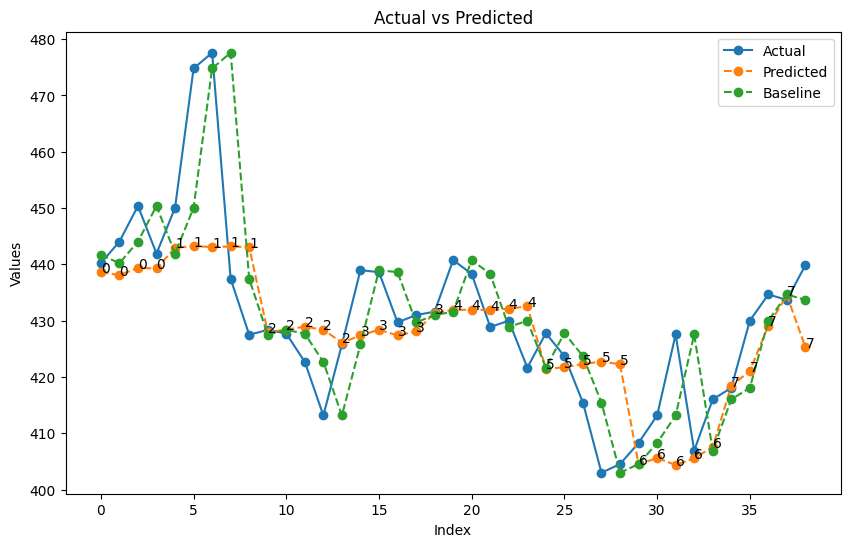

In [5]:
plot_actual_vs_predicted(val['y'][1:].reset_index(drop=True), val['NBEATS-median'][1:].reset_index(drop=True), val['y'].shift(1)[1:].reset_index(drop=True), val['modelID'][1:].reset_index(drop=True))